# 1. Inicializações

- REPO: https://github.com/derick-amontagna/master-degree-ufsc-electrical-engineering/tree/main/IIM/Study-Case-01

## 1.1. Bibliotecas

In [53]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import scipy
import datetime
import wfdb
from wfdb import rdrecord, processing

from scipy.signal import butter,filtfilt
import pywt

from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, balanced_accuracy_score, ConfusionMatrixDisplay

from xgboost import XGBClassifier

import os

from hrvanalysis import get_time_domain_features,get_frequency_domain_features, plot_psd
import matplotlib.pyplot as plt

from hyperactive import Hyperactive

## 1.2. Carregando os dados

Realizando o carregamento dados para todos os pacientes, assim como, realizando os seguintes procedimentos:
- Criando uma coluna para distinguir entre os sete pacientes;
- Criando uma coluna com a transformação do tipo string para TimeDelta da coluna que contem o tempo de cada amostra. (De maneira, de acordo com a frequência de amostragem, 200Hz corresponde a 1s). Nesse caso, será utilizado um tempo de 10s por cada janela;
- Criando a coluna referente ao janelamento de 10s.

In [2]:
data_all = pd.DataFrame()
# srate 200 Hz is 1s for the signal
seconds = 10
srate = seconds * 200
# All the folder
for sz in ['sz01', 'sz02', 'sz03', 'sz04', 'sz05', 'sz06', 'sz07']:
    # Leitura dos sinais
    patient=("dados" + f"\\{sz}")
    record = wfdb.rdrecord(patient)
    sig=record.p_signal[:,0]
    N=sig.shape[0]
    x=np.arange(N)
    # Carregando os dados para o DataFrame com algumas transformações
    data_sz = pd.DataFrame(x/(200), columns=['Time'])
    data_sz['Pacient'] = sz
    data_sz['TimeComplete'] = data_sz.Time.apply(lambda time: str(datetime.timedelta(seconds=time)))
    data_sz['TimeComplete'] = pd.to_timedelta(data_sz['TimeComplete'])
    data_sz['Signal'] = sig
    # Janelamento
    data_sz['window'] = 'x'
    i = 1
    for time in range(0, len(data_sz.Time), srate):
        data_sz.loc[time:time+srate, 'window'] = i
        i += 1
    
    data_all = pd.concat([data_all, data_sz])

In [3]:
data_all.head()

,Time,Pacient,TimeComplete,Signal,window
0,0.000,sz01,0 days 00:00:00,1.04,1
1,0.005,sz01,0 days 00:00:00.005000,1.08,1
2,0.010,sz01,0 days 00:00:00.010000,1.12,1
3,0.015,sz01,0 days 00:00:00.015000,1.16,1
4,0.020,sz01,0 days 00:00:00.020000,1.16,1


DataFrame criando pelo autor desse trabalho contendo todos os tempos que devem ser utilizado para a criação da coluna Target entre as quatro classes seguintes:
- N - normal;
- A - Pré-ictal (30 segundos antes das convulsões);
- I- Ictal (ocorrência das convulsões, com os tempos identificados aqui( https://www.physionet.org/content/szdb/1.0.0/times.seize)); 
- P-Pós-ictal (2 minutos após as convulsões);

In [4]:
# Atribuindo os labels
times = pd.read_csv(r"dados\timesAllPacient.csv", sep=';')

In [5]:
times.head()

,patient,two,N-I,N-F,A-I,A-F,I-I,I-F,P-I,P-F
0,sz01,False,0,0,0,00:14:36,00:14:36,00:16:12,00:16:12,01:29:59.985000
1,sz02-1,True,0,00:32:43,00:32:43,01:02:43,01:02:43,01:03:43,01:03:43,02:25:51
2,sz02-2,True,0,0,02:25:51,02:55:51,02:55:51,02:56:16,02:56:16,03:29:59.985000
3,sz03-1,True,0,00:54:34,00:54:34,01:24:34,01:24:34,01:26:22,01:26:22,02:04:27
4,sz03-2,True,0,0,02:04:27,02:34:27,02:34:27,02:36:17,02:36:17,03:45:59.985000


## 1.3. Explorando os dados

In [6]:
# Plotando o momento de Epilepsia do paciente sz01
temp = data_all[data_all['Pacient'] == 'sz01'].iloc[175500:179000]
fig = go.Figure(data=go.Scatter(x=temp.Time, y=temp.Signal))
fig

In [7]:
# Verificando os tempos maximos de cada sinal de cada paciente
for sz in ['sz01', 'sz02', 'sz03', 'sz04', 'sz05', 'sz06', 'sz07']:
    print(f'O tempo max de {sz} é {data_all[data_all["Pacient"] == sz].TimeComplete.max()}')

O tempo max de sz01 é 0 days 01:29:59.985000
O tempo max de sz02 é 0 days 03:29:59.985000
O tempo max de sz03 é 0 days 03:45:59.985000
O tempo max de sz04 é 0 days 01:29:59.985000
O tempo max de sz05 é 0 days 01:30:00.025000
O tempo max de sz06 é 0 days 02:59:59.985000
O tempo max de sz07 é 0 days 01:59:59.985000


# 2. Preprocessamento

## 2.1. Tempo

In [8]:
# Realizando a transformação das colunas de string para timedelta.
columns_time = times.drop(['patient', 'two'], axis=1).columns
for column in list(columns_time):
    times[column] = pd.to_timedelta(times[column])
Change = {'True': True, 'False': False}
times["two"] = times["two"].replace(Change)

In [9]:
times.head()

,patient,two,N-I,N-F,A-I,A-F,I-I,I-F,P-I,P-F
0,sz01,False,0 days,0 days 00:00:00,0 days 00:00:00,0 days 00:14:36,0 days 00:14:36,0 days 00:16:12,0 days 00:16:12,0 days 01:29:59.985000
1,sz02-1,True,0 days,0 days 00:32:43,0 days 00:32:43,0 days 01:02:43,0 days 01:02:43,0 days 01:03:43,0 days 01:03:43,0 days 02:25:51
2,sz02-2,True,0 days,0 days 00:00:00,0 days 02:25:51,0 days 02:55:51,0 days 02:55:51,0 days 02:56:16,0 days 02:56:16,0 days 03:29:59.985000
3,sz03-1,True,0 days,0 days 00:54:34,0 days 00:54:34,0 days 01:24:34,0 days 01:24:34,0 days 01:26:22,0 days 01:26:22,0 days 02:04:27
4,sz03-2,True,0 days,0 days 00:00:00,0 days 02:04:27,0 days 02:34:27,0 days 02:34:27,0 days 02:36:17,0 days 02:36:17,0 days 03:45:59.985000


## 2.2. Sinais e Alvo

Realizando a atribuição de cada classe em seu devido tempo. Respeitando uma classe para cada janela. De maneira que, caso haja uma janela com duas classes, será atribuida a primeira classe atribuida.

In [10]:
patient = ['sz01','sz02','sz03','sz04','sz05','sz06','sz07']
data_final = pd.DataFrame()
for p in patient:
    if p in ['sz02','sz03','sz06']:
        sz = p
        sz_filter_1 = sz + '-1'
        sz_filter_2 = sz + '-2'
        key_1 = times[times['patient'] == sz_filter_1]['I-I'].index[0]
        key_2 = times[times['patient'] == sz_filter_2]['I-I'].index[0]

        data_szX = data_all[data_all['Pacient'] == sz].copy()
        data_szX['Target'] = np.where((data_szX['TimeComplete'] >= times[times['patient'] == sz_filter_1]['I-I'][key_1]) & (data_szX['TimeComplete'] <= times[times['patient'] == sz_filter_1]['I-F'][key_1]), 'I', 'N')
        data_szX['Target'] = np.where((data_szX['TimeComplete'] >= times[times['patient'] == sz_filter_1]['A-I'][key_1]) & (data_szX['TimeComplete'] < times[times['patient'] == sz_filter_1]['A-F'][key_1]), 'A', data_szX['Target'])
        data_szX['Target'] = np.where((data_szX['TimeComplete'] > times[times['patient'] == sz_filter_1]['P-I'][key_1]) & (data_szX['TimeComplete'] <= times[times['patient'] == sz_filter_1]['P-F'][key_1]), 'P', data_szX['Target'])
        data_szX['Target'] = np.where((data_szX['TimeComplete'] >= times[times['patient'] == sz_filter_2]['I-I'][key_2]) & (data_szX['TimeComplete'] <= times[times['patient'] == sz_filter_2]['I-F'][key_2]), 'I', data_szX['Target'])
        data_szX['Target'] = np.where((data_szX['TimeComplete'] >= times[times['patient'] == sz_filter_2]['A-I'][key_2]) & (data_szX['TimeComplete'] < times[times['patient'] == sz_filter_2]['A-F'][key_2]), 'A', data_szX['Target'])
        data_szX['Target'] = np.where((data_szX['TimeComplete'] > times[times['patient'] == sz_filter_2]['P-I'][key_2]) & (data_szX['TimeComplete'] <= times[times['patient'] == sz_filter_2]['P-F'][key_2]), 'P', data_szX['Target'])
        data_final = pd.concat([data_final, data_szX])
    else:
        sz = p
        sz_filter_1 = p
        key_1 = times[times['patient'] == sz_filter_1]['I-I'].index[0]

        data_szX = data_all[data_all['Pacient'] == sz].copy()
        data_szX['Target'] = np.where((data_szX['TimeComplete'] >= times[times['patient'] == sz_filter_1]['I-I'][key_1]) & (data_szX['TimeComplete'] <= times[times['patient'] == sz_filter_1]['I-F'][key_1]), 'I', 'N')
        data_szX['Target'] = np.where((data_szX['TimeComplete'] >= times[times['patient'] == sz_filter_1]['A-I'][key_1]) & (data_szX['TimeComplete'] < times[times['patient'] == sz_filter_1]['A-F'][key_1]), 'A', data_szX['Target'])
        data_szX['Target'] = np.where((data_szX['TimeComplete'] > times[times['patient'] == sz_filter_1]['P-I'][key_1]) & (data_szX['TimeComplete'] <= times[times['patient'] == sz_filter_1]['P-F'][key_1]), 'P', data_szX['Target'])

        data_final = pd.concat([data_final, data_szX])



Criando o filtro passa-baixa com frequência de corte de 40Hz de ordem 4.
Demostrando a efetividade do filtro com uma amostra do paciente sz01

In [11]:
## Filter Butter-Lowpass Filter
# Filter requirements.
data = data_final[data_final.Pacient == 'sz01'].loc[2000:3000,'Signal'].values
time = x = data_final[data_final.Pacient == 'sz01'].loc[2000:3000,'Time'].values
T = 1.0         # Sample Period
fs = 1000       # sample rate, Hz
fc = 40         # Desired cutoff frequency of the filter, Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 4       # Order filter
n = int(T * fs) # total number of samples

def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='lowpass', analog=False)

    # filter the data with the coefficients b,a
    y = filtfilt(b, a, data)
    return y

# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(data, fc, fs, order)

fig = go.Figure()

fig.update_layout(
    title="Signal from sz01",
    xaxis_title="time/second",
    yaxis_title="mV",
)
fig.add_trace(go.Scatter(
            y = data,
            x = time,
            line =  dict(shape =  'spline' ),
            name = 'Original'
            ))
fig.add_trace(go.Scatter(
            y = y,
            x = time,
            line =  dict(shape =  'spline' ),
            name = 'Filtered'
            ))
            
fig.show()

Aplicando o filtro para todos os sinais de todos os pacientes com as mesmas frequência de corte e ordem

In [12]:
data_final['Signal_Filter'] = butter_lowpass_filter(data_final['Signal'].values, fc, fs, order)

## 2.3. Criação do conjunto de treinamento e teste

Criação do numpy array por meio do agrupamento da coluna do paciente e a janela correspondente. Resultando em um numpy array contendo (Número da amostra (paciente + janelamento), Sinal do janelamento). Apos isso, 
é realizando uma correção da dimensão que contem o sinal para todos terem a mesma largura. (Amostra, Sinal)

In [13]:
def pad_zero(data):
    an_array = np.array(data)
    shape = np.shape(an_array)
    padded_array = np.zeros((2000,))
    padded_array[:shape[0]] = an_array
    return padded_array

In [14]:
data_x = data_final.groupby(['Pacient', 'window'])['Signal_Filter'].agg(lambda x: x.tolist()).values
X = np.vstack([pad_zero(np.array(data_x[i])) for i in range(len(data_x))])

In [15]:
X.shape

(6037, 2000)

Como a criação da coluna alvo foi feita seguindo a regra que cada janela teria apenas um alvo, temos um alvo para cada amostra.

In [16]:
data_y =  data_final.groupby(['Pacient', 'window'])['Target'].agg(lambda x: x.tolist()).values
y = np.array([', '.join(set(data_y[i]))[0] for i in range(0, len(data_y))])


In [17]:
y.shape

(6037,)

Por fim, é realizando a criação dos conjuntos de treinamento e teste. Sendo, 30% dos dados para o conjunto de teste, realizando uma estratificação para a coluna alvo.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. Criação de atributos

Os atributos foram retidas do seguinte artigo: < A. Balachandran, M. Ganesan and E. P. Sumesh, "Daubechies algorithm for highly accurate ECG feature extraction," 2014 International Conference on Green Computing Communication and Electrical Engineering (ICGCCEE), Coimbatore, India, 2014, pp. 1-5, doi: 10.1109/ICGCCEE.2014.6922266.>

Foram escolhidos esses atributos devido a sua frequência de uso na maioria dos artigos da area.

## 3.1. Atributos no dominio do tempo e frequência

In [19]:
def calculate_statistics(list_values):
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    return [n5, n25, n75, n95, median, mean, std, var, rms]

In [20]:
def get_features(list_values):
    statistics = calculate_statistics(list_values)
    return statistics

In [21]:
def apply_features(dataset, waveletname = 'rbio3.1'):
    all_features = []
    for signal_no in range(0, len(dataset)):
        # Select the window signal 
        signal = dataset[signal_no, :]
        features_time = []
        features_freq = []
        # Calculate the features stats in time
        features_time = get_features(signal)
        # Calculate the Wavelet Discrete all level
        list_coeff = pywt.wavedec(signal, waveletname)
        for coeff in list_coeff:
            # Calculate the features stats in freq
            features_freq += get_features(coeff)
        all_features.append(features_time + features_freq)
    return np.array(all_features)


In [22]:
# Atributos de treinamento
X_features = apply_features(X_train, 'rbio3.1')

In [23]:
X_features.shape ## (Amostras, Número de atributos)

(4225, 99)

In [24]:
# Atributos de teste
X_features_test = apply_features(X_test, 'rbio3.1')

In [25]:
X_features_test.shape ## (Amostras, Número de atributos)

(1812, 99)

## 3.2. Criação de atributos por meio da variabilidade cardiaca dos pacientes

c:\Users\doxda\anaconda3\envs\py39IIM\lib\site-packages\scipy\signal\_spectral_py.py:1961: UserWarning:

nperseg = 256 is greater than input length  = 13, using nperseg = 13



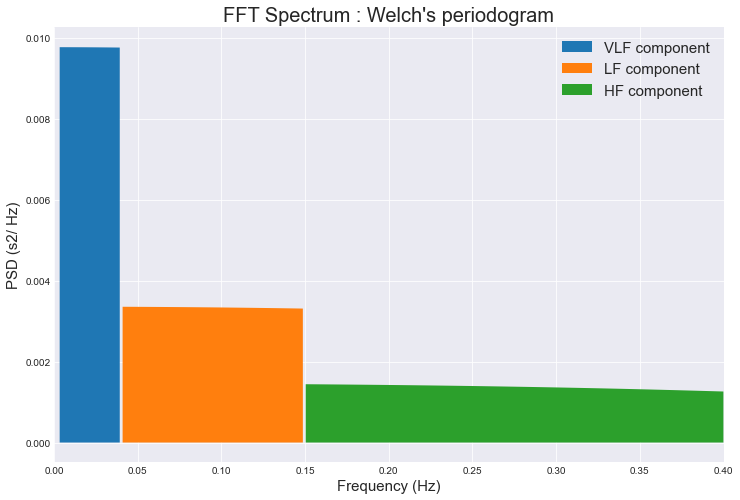

In [26]:
# Visualizando a HRV
rr_interval =  np.diff(wfdb.processing.find_local_peaks(X_train[0, :], 100))
plot_psd(rr_interval, method='welch')

In [27]:
def calculate_stats_time(list_values):  
    features = get_time_domain_features(list_values)
    return list(features.values())
    

In [28]:
def calculate_stats_freq(list_values):
    features = get_frequency_domain_features(list_values)
    return list(features.values())

In [29]:
def get_features_hrv(list_values):
    time = calculate_stats_time(list_values)
    freq = calculate_stats_freq(list_values)
    return time + freq

In [30]:
def apply_features_hrv(dataset, radius = 100):
    all_features = []
    for signal_no in range(0, len(dataset)):
        # Select the window signal 
        signal = dataset[signal_no, :]
        # Calculate the RR Interval
        rr_interval =  np.diff(wfdb.processing.find_local_peaks(signal, radius))
        # Save Feature
        all_features.append(get_features_hrv(rr_interval))
    return np.array(all_features)


In [31]:
# Atributos de treinamento
X_features_hrv = apply_features_hrv(X_train)

c:\Users\doxda\anaconda3\envs\py39IIM\lib\site-packages\scipy\signal\_spectral_py.py:1961: UserWarning:

nperseg = 256 is greater than input length  = 7, using nperseg = 7

c:\Users\doxda\anaconda3\envs\py39IIM\lib\site-packages\scipy\signal\_spectral_py.py:1961: UserWarning:

nperseg = 256 is greater than input length  = 8, using nperseg = 8

c:\Users\doxda\anaconda3\envs\py39IIM\lib\site-packages\scipy\signal\_spectral_py.py:1961: UserWarning:

nperseg = 256 is greater than input length  = 6, using nperseg = 6

c:\Users\doxda\anaconda3\envs\py39IIM\lib\site-packages\scipy\signal\_spectral_py.py:1961: UserWarning:

nperseg = 256 is greater than input length  = 5, using nperseg = 5

c:\Users\doxda\anaconda3\envs\py39IIM\lib\site-packages\scipy\signal\_spectral_py.py:1961: UserWarning:

nperseg = 256 is greater than input length  = 4, using nperseg = 4



In [32]:
X_features_hrv.shape ## (Amostras, Número de atributos)

(4225, 23)

In [33]:
# Atributos de teste
X_features_hrv_test = apply_features_hrv(X_test)

In [34]:
X_features_hrv_test.shape ## (Amostras, Número de atributos)

(1812, 23)

# 4. Criação dos modelos

## 4.1. Dominio do tempo e frequência

### 4.1.1. Modelo Dummy

In [35]:
# Modelo base para conseguir ter um minimo necessario para alcançar um bom modelo
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_features, y_train)
train_score = dummy_clf.score(X_features, y_train)
test_score = dummy_clf.score(X_features_test, y_test)
print(f"Train Score for the dataset is about: {train_score:.2f}")
print(f"Test Score for the dataset is about: {test_score:.2f}")

Train Score for the dataset is about: 0.57
Test Score for the dataset is about: 0.57


In [36]:
y_pred = dummy_clf.predict(X_features_test)
print(f"Test Balanced Accuracy for the dataset is about: {balanced_accuracy_score(y_test, y_pred):.2f}")

Test Balanced Accuracy for the dataset is about: 0.25


### 4.1.2. Logistic Regression

In [63]:
lr_clf = LogisticRegression(random_state=42, max_iter=10000)
lr_clf.fit(X_features, y_train)
train_score = lr_clf.score(X_features, y_train)
test_score = lr_clf.score(X_features_test, y_test)
print(f"Train Score for the dataset is about: {train_score:.2f}")
print(f"Test Score for the dataset is about: {test_score:.2f}")

Train Score for the dataset is about: 0.64
Test Score for the dataset is about: 0.62


In [64]:
y_pred = lr_clf.predict(X_features_test)
print(f"Test Balanced Accuracy for the dataset is about: {balanced_accuracy_score(y_test, y_pred):.2f}")

Test Balanced Accuracy for the dataset is about: 0.34


In [65]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.66      0.19      0.30       482
           I       0.12      0.04      0.06        24
           N       0.54      0.15      0.24       265
           P       0.63      0.96      0.76      1041

    accuracy                           0.62      1812
   macro avg       0.49      0.34      0.34      1812
weighted avg       0.62      0.62      0.55      1812



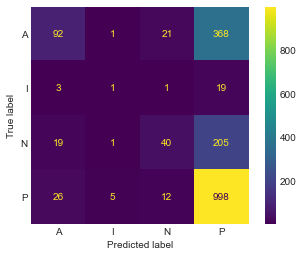

In [66]:
ConfusionMatrixDisplay.from_estimator(lr_clf, X_features_test, y_test)  
plt.grid(False)

### 4.1.3. SVM

In [67]:
svc_clf = SVC(random_state=42, kernel='poly')
svc_clf.fit(X_features, y_train)
train_score = svc_clf.score(X_features, y_train)
test_score = svc_clf.score(X_features_test, y_test)
print(f"Train Score for the dataset is about: {train_score:.2f}")
print(f"Test Score for the dataset is about: {test_score:.2f}")

Train Score for the dataset is about: 0.58
Test Score for the dataset is about: 0.57


In [68]:
y_pred = svc_clf.predict(X_features_test)
print(f"Test Balanced Accuracy for the dataset is about: {balanced_accuracy_score(y_test, y_pred):.2f}")

Test Balanced Accuracy for the dataset is about: 0.25


In [69]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.00      0.00      0.00       482
           I       0.00      0.00      0.00        24
           N       0.00      0.00      0.00       265
           P       0.57      0.99      0.73      1041

    accuracy                           0.57      1812
   macro avg       0.14      0.25      0.18      1812
weighted avg       0.33      0.57      0.42      1812



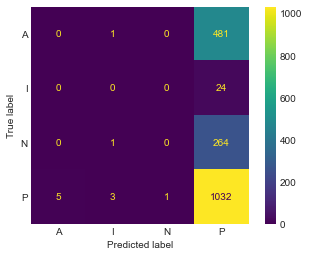

In [70]:
ConfusionMatrixDisplay.from_estimator(svc_clf, X_features_test, y_test)  
plt.grid(False)

### 4.1.4. XGBoost

In [71]:
xgbc = XGBClassifier(use_label_encoder=True, eval_metric='mlogloss')
xgbc.fit(X_features, y_train)
train_score = xgbc.score(X_features, y_train)
test_score = xgbc.score(X_features_test, y_test)
print(f"Train Score for the dataset is about: {train_score:.2f}")
print(f"Test Score for the dataset is about: {test_score:.2f}")

c:\Users\doxda\anaconda3\envs\py39IIM\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



Train Score for the dataset is about: 1.00
Test Score for the dataset is about: 0.91


In [72]:
y_pred = xgbc.predict(X_features_test)
print(f"Test Balanced Accuracy for the dataset is about: {balanced_accuracy_score(y_test, y_pred):.2f}")

Test Balanced Accuracy for the dataset is about: 0.67


In [73]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.92      0.83      0.87       482
           I       0.00      0.00      0.00        24
           N       0.87      0.86      0.86       265
           P       0.92      0.98      0.95      1041

    accuracy                           0.91      1812
   macro avg       0.68      0.67      0.67      1812
weighted avg       0.90      0.91      0.91      1812



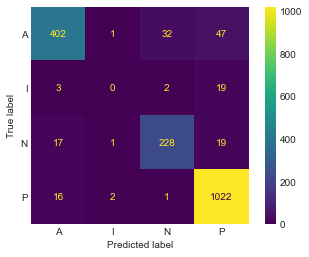

In [74]:
ConfusionMatrixDisplay.from_estimator(xgbc, X_features_test, y_test)  
plt.grid(False)

## 4.2. Variabilidade Cardiaca

### 4.2.1. Modelo Dummy

In [75]:
# Modelo base para conseguir ter um minimo necessario para alcançar um bom modelo
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_features_hrv, y_train)
train_score = dummy_clf.score(X_features_hrv, y_train)
test_score = dummy_clf.score(X_features_hrv_test, y_test)
print(f"Train Score for the dataset is about: {train_score:.2f}")
print(f"Test Score for the dataset is about: {test_score:.2f}")

Train Score for the dataset is about: 0.57
Test Score for the dataset is about: 0.57


In [76]:
y_pred = dummy_clf.predict(X_features_hrv_test)
print(f"Test Balanced Accuracy for the dataset is about: {balanced_accuracy_score(y_test, y_pred):.2f}")

Test Balanced Accuracy for the dataset is about: 0.25


### 4.2.2. Logistic Regression

In [77]:
lr_clf = LogisticRegression(random_state=42, max_iter=10000)
lr_clf.fit(X_features_hrv, y_train)
train_score = lr_clf.score(X_features_hrv, y_train)
test_score = lr_clf.score(X_features_hrv_test, y_test)
print(f"Train Score for the dataset is about: {train_score:.2f}")
print(f"Test Score for the dataset is about: {test_score:.2f}")

Train Score for the dataset is about: 0.57
Test Score for the dataset is about: 0.58


c:\Users\doxda\anaconda3\envs\py39IIM\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [78]:
y_pred = lr_clf.predict(X_features_hrv_test)
print(f"Test Balanced Accuracy for the dataset is about: {balanced_accuracy_score(y_test, y_pred):.2f}")

Test Balanced Accuracy for the dataset is about: 0.29


In [79]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.30      0.09      0.14       482
           I       1.00      0.04      0.08        24
           N       0.55      0.11      0.18       265
           P       0.60      0.94      0.73      1041

    accuracy                           0.58      1812
   macro avg       0.61      0.29      0.28      1812
weighted avg       0.52      0.58      0.49      1812



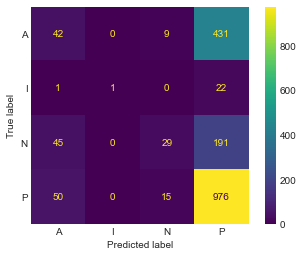

In [80]:
ConfusionMatrixDisplay.from_estimator(lr_clf, X_features_hrv_test, y_test)  
plt.grid(False)

### 4.2.3. SVM

In [81]:
svc_clf = SVC(random_state=42, kernel='poly')
svc_clf.fit(X_features_hrv, y_train)
train_score = svc_clf.score(X_features_hrv, y_train)
test_score = svc_clf.score(X_features_hrv_test, y_test)
print(f"Train Score for the dataset is about: {train_score:.2f}")
print(f"Test Score for the dataset is about: {test_score:.2f}")

Train Score for the dataset is about: 0.58
Test Score for the dataset is about: 0.58


In [82]:
y_pred = svc_clf.predict(X_features_hrv_test)
print(f"Test Balanced Accuracy for the dataset is about: {balanced_accuracy_score(y_test, y_pred):.2f}")

Test Balanced Accuracy for the dataset is about: 0.25


In [83]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.57      0.01      0.02       482
           I       0.00      0.00      0.00        24
           N       0.00      0.00      0.00       265
           P       0.58      1.00      0.73      1041

    accuracy                           0.58      1812
   macro avg       0.29      0.25      0.19      1812
weighted avg       0.48      0.58      0.42      1812



c:\Users\doxda\anaconda3\envs\py39IIM\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\doxda\anaconda3\envs\py39IIM\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\doxda\anaconda3\envs\py39IIM\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



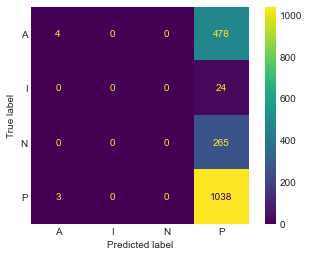

In [84]:
ConfusionMatrixDisplay.from_estimator(svc_clf, X_features_hrv_test, y_test)  
plt.grid(False)

### 4.2.4. XGBoost

In [85]:
xgbc = XGBClassifier(use_label_encoder=True, eval_metric='mlogloss')
xgbc.fit(X_features_hrv, y_train)
train_score = xgbc.score(X_features_hrv, y_train)
test_score = xgbc.score(X_features_hrv_test, y_test)
print(f"Train Score for the dataset is about: {train_score:.2f}")
print(f"Test Score for the dataset is about: {test_score:.2f}")

c:\Users\doxda\anaconda3\envs\py39IIM\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



Train Score for the dataset is about: 0.98
Test Score for the dataset is about: 0.61


In [86]:
y_pred = xgbc.predict(X_features_hrv_test)
print(f"Test Balanced Accuracy for the dataset is about: {balanced_accuracy_score(y_test, y_pred):.2f}")

Test Balanced Accuracy for the dataset is about: 0.36


In [87]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.46      0.36      0.40       482
           I       0.00      0.00      0.00        24
           N       0.47      0.26      0.33       265
           P       0.67      0.83      0.74      1041

    accuracy                           0.61      1812
   macro avg       0.40      0.36      0.37      1812
weighted avg       0.58      0.61      0.58      1812



c:\Users\doxda\anaconda3\envs\py39IIM\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\doxda\anaconda3\envs\py39IIM\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\doxda\anaconda3\envs\py39IIM\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



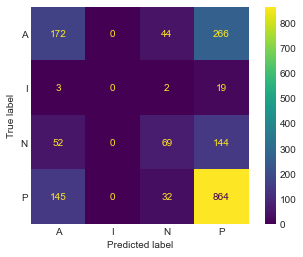

In [88]:
ConfusionMatrixDisplay.from_estimator(xgbc, X_features_hrv_test, y_test)  
plt.grid(False)

# 5. Comparação dos modelos

Comparando com o artigo:
- Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.)
< https://doi.org/10.1161/01.CIR.101.23.e215 > 

Esse trabalho, somente com o modelo puro (sem a realização de uma tunagem do modelo), alcançou uma acuracia balanceada de 67\% (XGBoost) para o dominio do tempo e frequencia. Para o HRV, os modelos não tiveram um bom resultado, ficanfo muito proximo do Modelo Dummy.